<a href="https://colab.research.google.com/github/adrianfr10/forecasting-analysis-semantics-assignments/blob/master/Task_2_Analysis_of_sellers_and_products.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING LIBRARIES

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

LOADING DATA

In [17]:
sellers = pd.read_csv('sellers.csv', encoding='utf-8')
products = pd.read_csv('products.csv', encoding='utf-8')
order_items = pd.read_csv('order_items.csv', encoding='utf-8')
translations = pd.read_csv('product_category_name_translation.csv', encoding='utf-8')

DATA EXPLORATION

In [22]:
print('=============================sellers=============================')
print(sellers.info())
print('===============================')
print("Shape:", sellers.shape)
print('===============================')
print(sellers.describe())
print('=============================products=============================')
print(products.info())
print('===============================')
print("Shape:", products.shape)
print('===============================')
print(products.describe())
print('=============================order_items=============================')
print(order_items.info())
print('===============================')
print("Shape:", order_items.shape)
print('===============================')
print(order_items.describe())
print('=============================translations=============================')
print(translations.info())
print('===============================')
print("Shape:", translations.shape)
print('===============================')
print(translations.describe())

=============================sellers=============================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
None
Shape: (3095, 4)
       seller_zip_code_prefix
count             3095.000000
mean             32291.059451
std              32713.453830
min               1001.000000
25%               7093.500000
50%              14940.000000
75%              64552.500000
max              99730.000000
=============================products=============================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns)

ALTERING DATA

In [23]:
# Translating column "product_category_name" to english language
products = products.merge(translations, on='product_category_name', how='left')
products.drop('product_category_name', axis=1, inplace=True)
products.rename(columns={'product_category_name_english': 'product_category_name'}, inplace=True)

SELLERS ANALYSIS

Seller with the highest turnover:
                             seller_id  seller_zip_code_prefix seller_city  \
2617  4869f7a5dfa277a7dca6462dcf3b52b2                   14840     guariba   

     seller_state  
2617           SP  

Seller with the lowest turnover:
                             seller_id  seller_zip_code_prefix seller_city  \
2211  cf6f6bc4df3999b9c6440f124fb2f687                    4937   sao paulo   

     seller_state  
2211           SP  


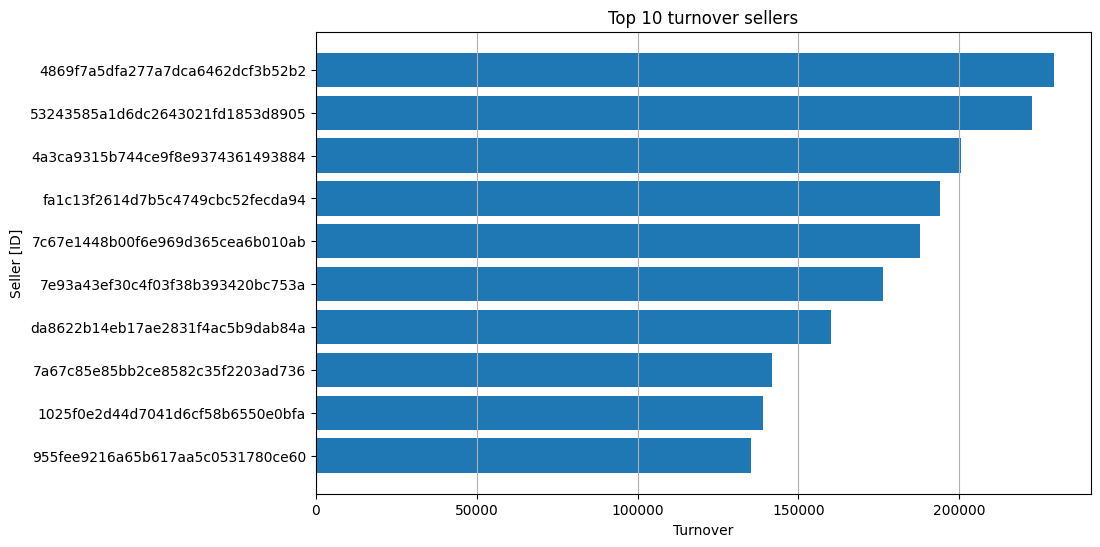

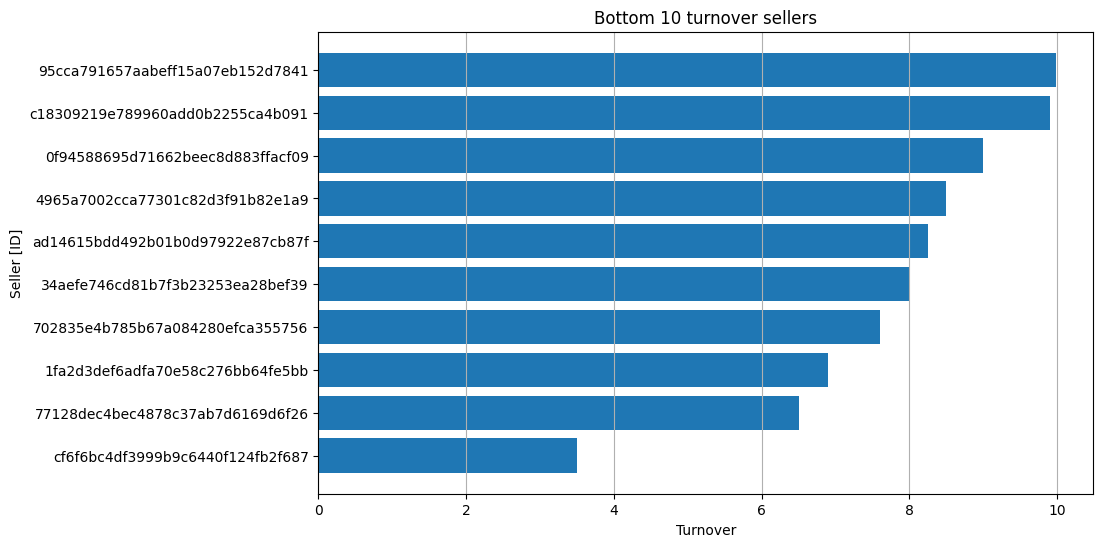

In [24]:
# SELLERS TURNOVER
sellers_with_order_items = pd.merge(order_items, sellers, on='seller_id')

# Calculating turnover for every seller
# Assuming that Freight Value is an expense covered by the buyer
# So it does not affect the turnover
turnover_by_seller = sellers_with_order_items.groupby('seller_id')['price'].sum().reset_index()
turnover_by_seller.rename(columns={'price':'turnover'}, inplace=True)
# Sorting by turnover ascending
turnover_by_seller = turnover_by_seller.sort_values(by='turnover', ascending=True)

# Getting max and min turnover seller IDs
max_turnover_seller_id = turnover_by_seller.loc[turnover_by_seller['turnover'].idxmax()]['seller_id']
min_turnover_seller_id = turnover_by_seller.loc[turnover_by_seller['turnover'].idxmin()]['seller_id']

# Seller with max turnover
max_turnover_seller = sellers[sellers['seller_id'] == max_turnover_seller_id]
# Seller with min turnover
min_turnover_seller = sellers[sellers['seller_id'] == min_turnover_seller_id]

# Printing out sellers with max and min turnover
print("Seller with the highest turnover:")
print(max_turnover_seller)

print("\nSeller with the lowest turnover:")
print(min_turnover_seller)

# Getting 10 sellers with the greatest turnover
top_sellers = turnover_by_seller.tail(10)

# Plotting 10 sellers with the greatest turnover
plt.figure(figsize=(10, 6))
plt.barh(top_sellers['seller_id'], top_sellers['turnover'])
plt.xlabel('Turnover')
plt.ylabel('Seller [ID]')
plt.grid(axis='x')
plt.title('Top 10 turnover sellers')
plt.show()

# Plotting 10 sellers with the lowest turnover
bottom_sellers = turnover_by_seller.head(10)
plt.figure(figsize=(10, 6))
plt.barh(bottom_sellers['seller_id'], bottom_sellers['turnover'])
plt.xlabel('Turnover')
plt.ylabel('Seller [ID]')
plt.grid(axis='x')
plt.title('Bottom 10 turnover sellers')
plt.show()


LEADERS IN SALES IN EACH AREA

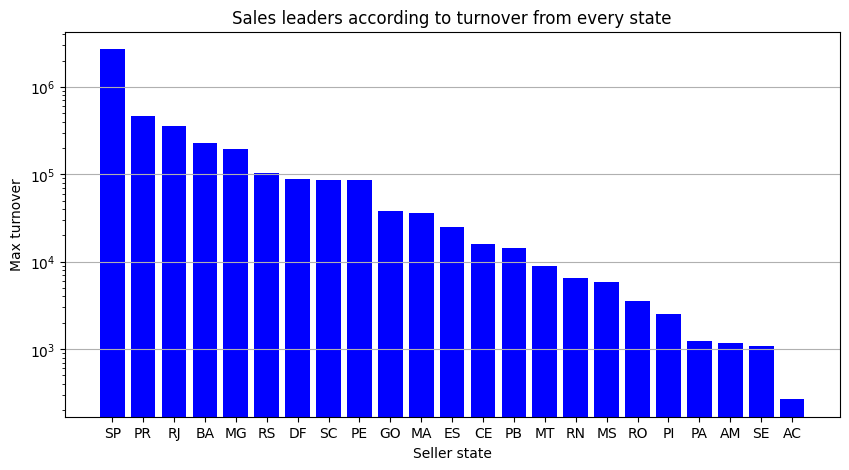

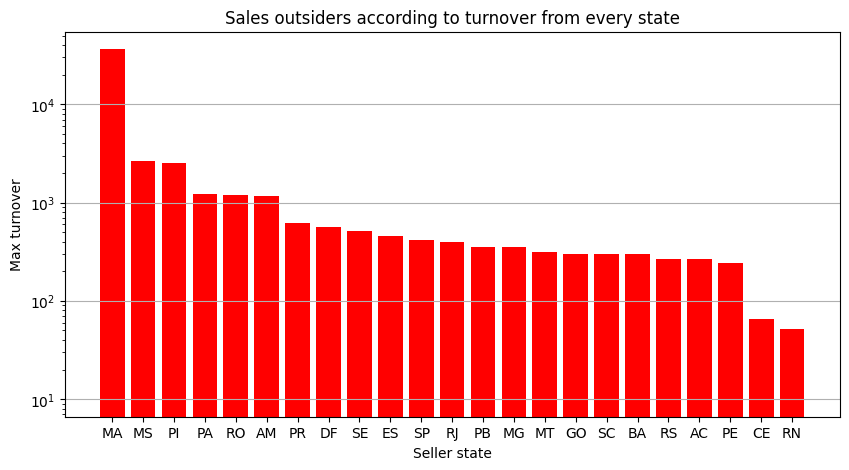

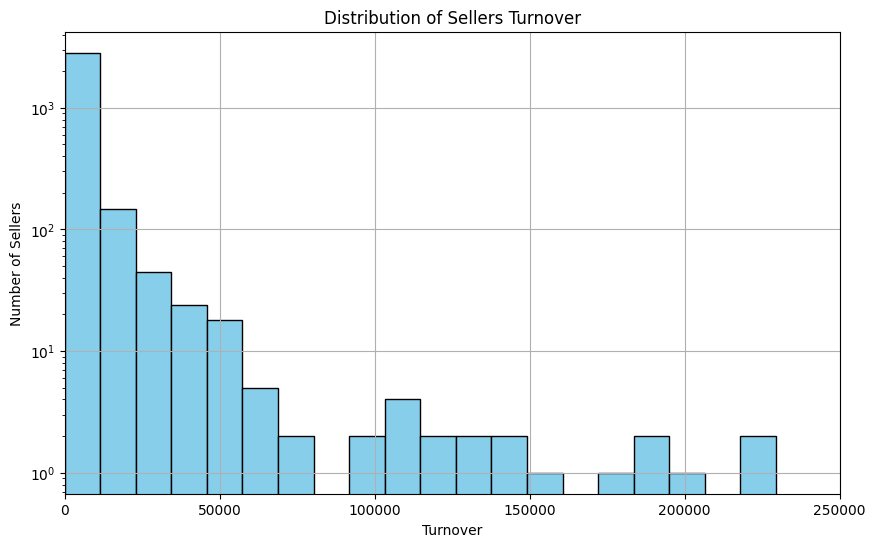

In [7]:
# Calculating turnover for every seller in every area
turnover_by_area = sellers_with_order_items.groupby(['seller_state', 'seller_city', 'seller_id'])['price'].sum().reset_index()
# Renaming column with sum of prices into "turnover"
turnover_by_area.rename(columns={'price':'turnover'}, inplace=True)
# Calculate turnover for every area (state and city)
turnover_by_region = turnover_by_area.groupby(['seller_state', 'seller_city'])['turnover'].sum().reset_index()
turnover_by_region.rename(columns={'price':'turnover'}, inplace=True)
# Sorting turnover for every area
turnover_by_region = turnover_by_region.sort_values(by=['seller_state', 'turnover'], ascending=[True, False])

# Function to get leaders for given group
def get_leader(group: pd.DataFrame) -> pd.DataFrame:
    """
    Function gets leaders from certain values group by the quantile metric
    :param group:
    :return:
    """
    leader_threshold = group.quantile(0.75)  # 75% quantile as leader threshold
    is_leader = group >= leader_threshold
    return group[is_leader]

# Function to get outsiders for given group
def get_outsider(group: pd.DataFrame) -> pd.DataFrame:
    """
    Function gets outsiders from certain values group by the quantile metric
    :param group:
    :return:
    """
    outsider_threshold = group.quantile(0.25)  # 25% quantile as outsider threshold
    is_outsider = group <= outsider_threshold
    return group[is_outsider]

# Grouping leaders by state and sorting by max turnover
leaders = turnover_by_region.groupby('seller_state')['turnover'].apply(get_leader).reset_index(name='max_turnover')
leaders = leaders.sort_values(by='max_turnover', ascending=False)

# Grouping outsiders by state and sorting by max turnover
outsiders = turnover_by_region.groupby('seller_state')['turnover'].apply(get_outsider).reset_index(name='min_turnover')
outsiders = outsiders.sort_values(by='min_turnover', ascending=False)

# Plotting turnover leaders from every area(state)
plt.figure(figsize=(10, 5))
plt.bar(leaders['seller_state'], leaders['max_turnover'], color='blue', log=True)
plt.xlabel('Seller state')
plt.ylabel('Max turnover')
plt.grid(axis='y')
plt.title('Sales leaders according to turnover from every state')
plt.show()

# Plotting turnover outsiders from every area(state)
plt.figure(figsize=(10, 5))
plt.bar(outsiders['seller_state'], outsiders['min_turnover'], color='red', log=True)
plt.xlabel('Seller state')
plt.ylabel('Max turnover')
plt.grid(axis='y')
plt.title('Sales outsiders according to turnover from every state')
plt.show()

# Histogram with sellers turnover distribution
plt.figure(figsize=(10, 6))
plt.hist(turnover_by_seller['turnover'], bins=20, color='skyblue', edgecolor='black', log=True)
plt.xlabel('Turnover')
plt.ylabel('Number of Sellers')
plt.grid(axis='y')
plt.xlim([0, 250000])
plt.title('Distribution of Sellers Turnover')
plt.grid(True)
plt.show()

PRODUCTS ANALYSIS

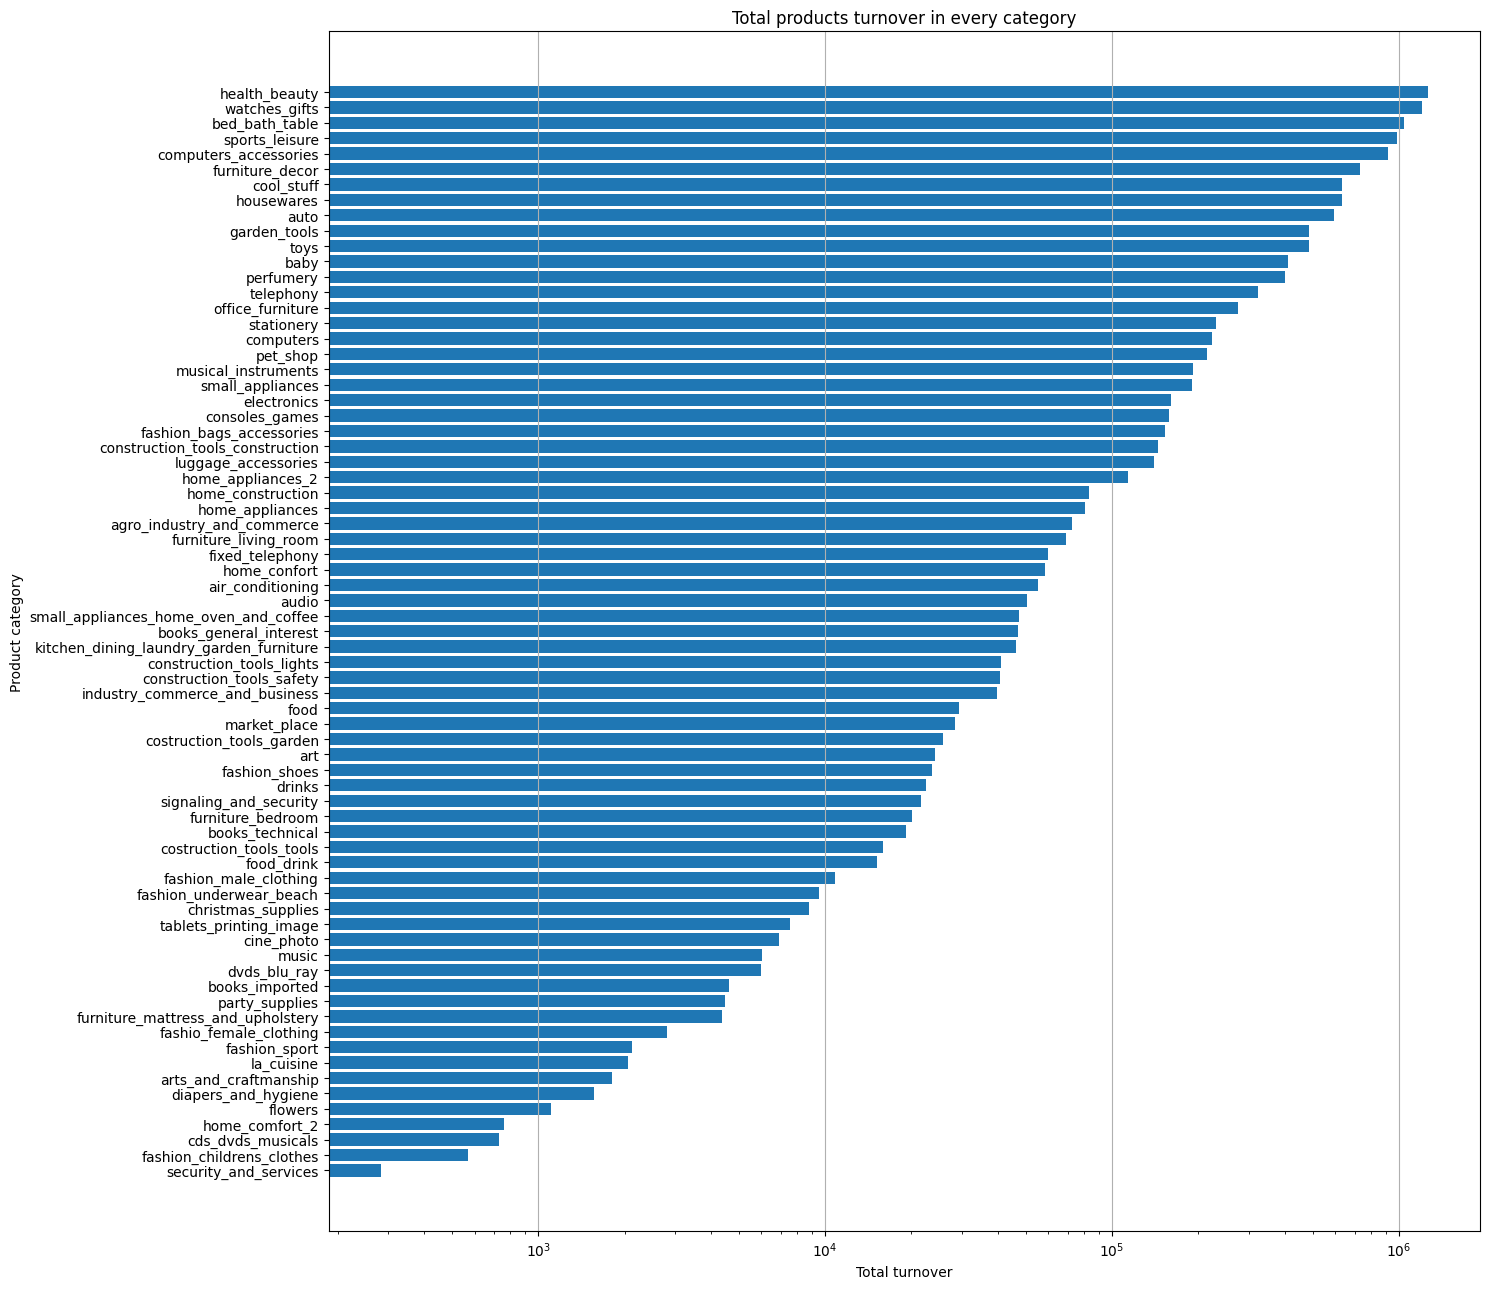

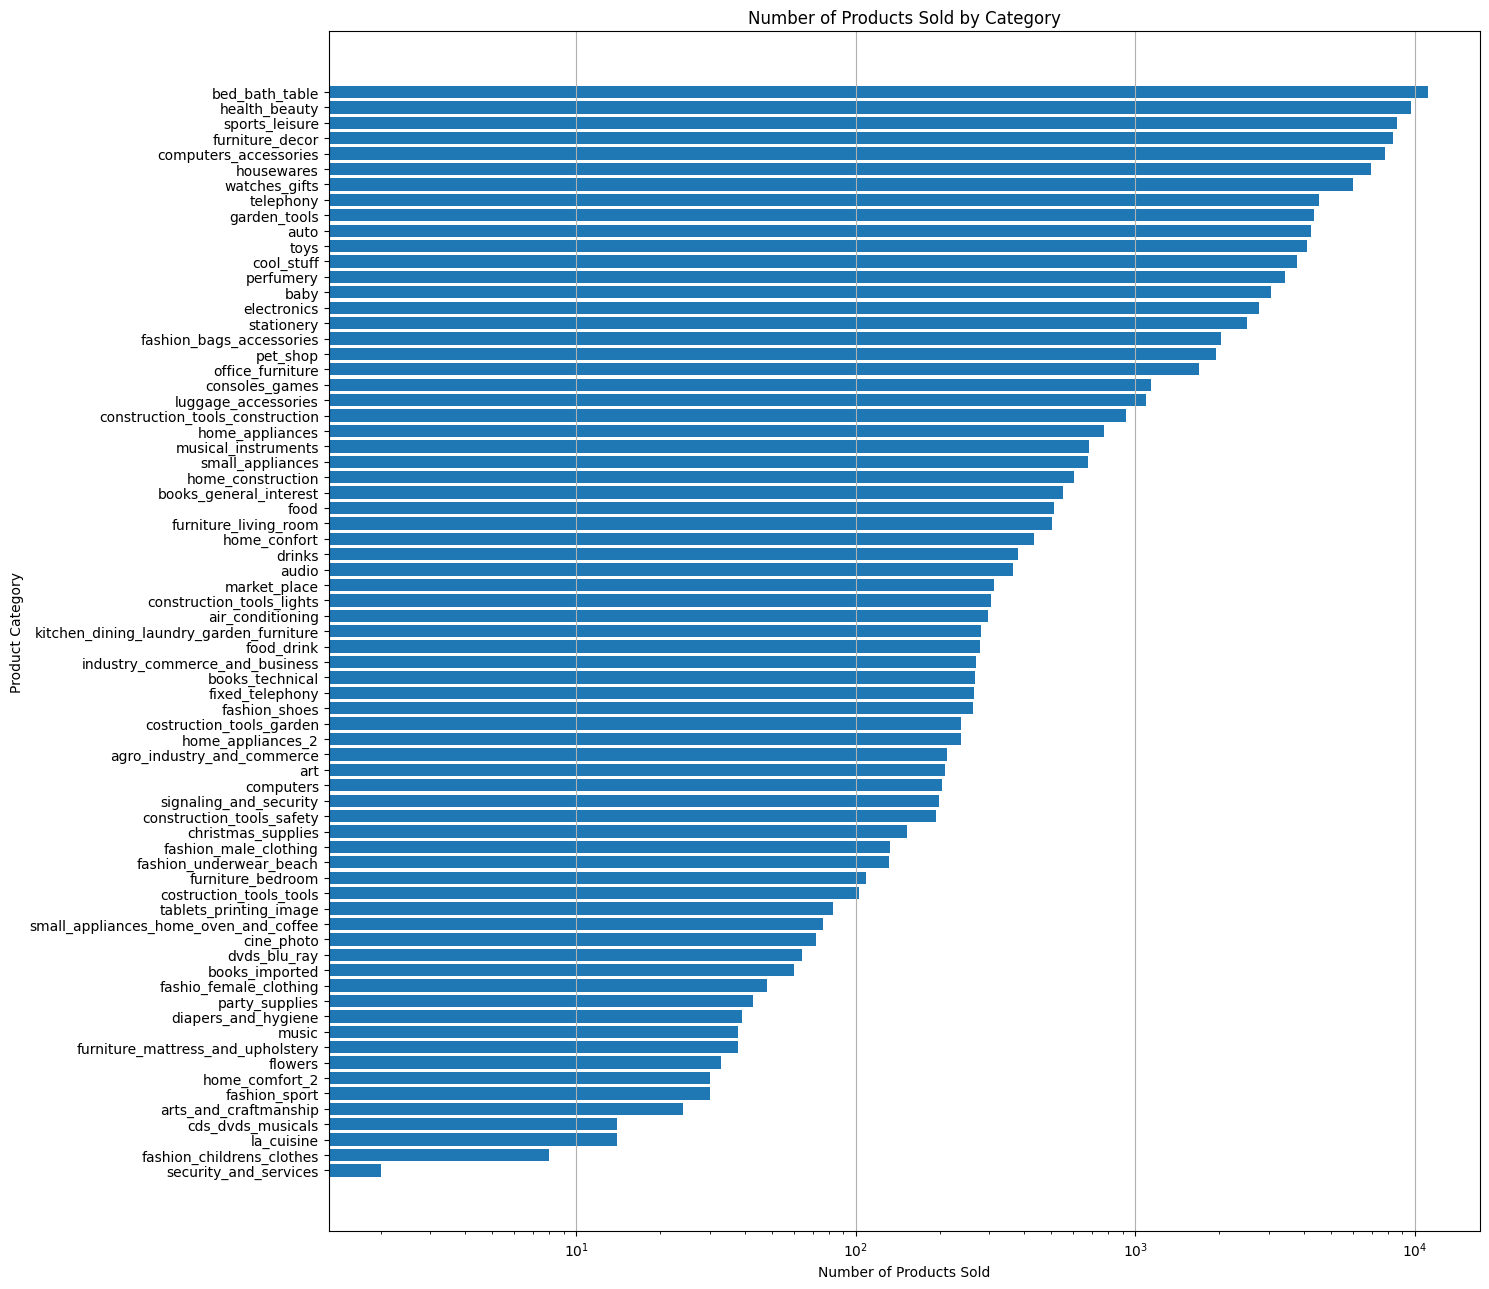

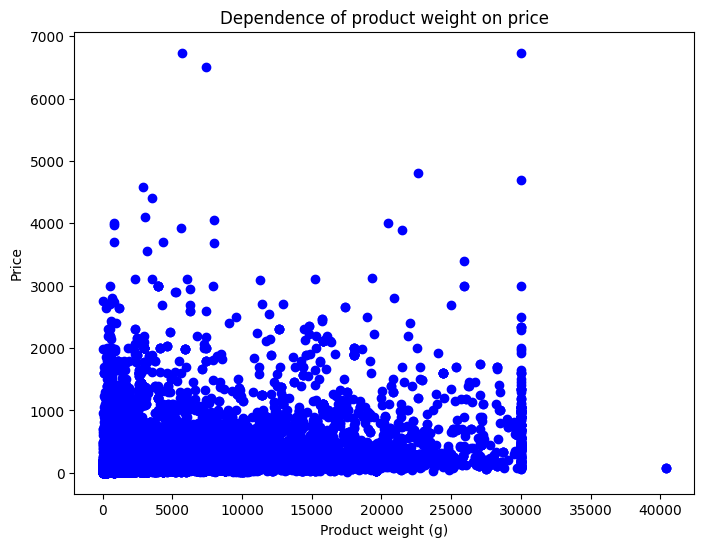

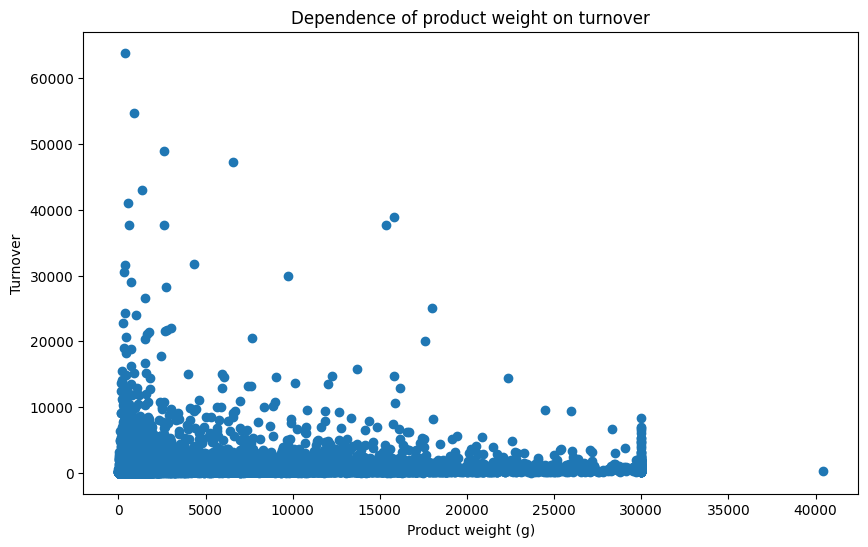

In [8]:
# Merging products and order_items DataFrames
products_with_orders = pd.merge(products, order_items, on='product_id')

# Calculating turnover for every category of products
turnover_by_category = products_with_orders.groupby(['product_category_name'])['price'].sum().reset_index()
# Renaming column 'price' into 'turnover' and sorting by turnover value ascending
turnover_by_category.rename(columns={'price':'turnover'}, inplace=True)
turnover_by_category.sort_values(by='turnover', ascending=True, inplace=True)

# Getting best-selling products from each category basing on turnover
top_selling_products = products_with_orders.loc[products_with_orders.groupby('product_category_name')['price'].idxmax()]

# Bar plot for turnover in each category
plt.figure(figsize=(15, 13))
plt.barh(turnover_by_category['product_category_name'], turnover_by_category['turnover'], log=True)
plt.xlabel('Total turnover')
plt.ylabel('Product category')
plt.title('Total products turnover in every category')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

# Calculating product sales count for each product in product_sales DataFrame
product_sales = products_with_orders.groupby(['product_id', 'product_category_name'])['order_item_id'].count().reset_index()
product_sales.rename(columns={'order_item_id': 'quantity_sold'}, inplace=True)

# Calculating product sales count for each category and sorting by max quantity ascending
category_sales = product_sales.groupby('product_category_name')['quantity_sold'].sum().reset_index()
category_sales = category_sales.sort_values(by='quantity_sold', ascending=True)

# Plotting product sales for each category
plt.figure(figsize=(15, 13))
plt.barh(category_sales['product_category_name'], category_sales['quantity_sold'], log=True)
plt.xlabel('Number of Products Sold')
plt.ylabel('Product Category')
plt.title('Number of Products Sold by Category')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Plotting affect of product weight on its price
plt.figure(figsize=(8, 6))
plt.scatter(products_with_orders['product_weight_g'], products_with_orders['price'], c='blue')
plt.xlabel('Product weight (g)')
plt.ylabel('Price')
plt.title('Dependence of product weight on price')
plt.show()

# Calculating turnover for each product
product_turnover = products_with_orders.groupby(['product_id']).agg({'price': 'sum', 'product_weight_g': 'first'}).reset_index()
product_turnover = product_turnover.rename(columns={'price': 'turnover'})
plt.figure(figsize=(10, 6))

# Plotting affect of product weight on turnover
plt.scatter(product_turnover['product_weight_g'], product_turnover['turnover'])
plt.xlabel('Product weight (g)')
plt.ylabel('Turnover')
plt.title('Dependence of product weight on turnover')
plt.show()

SEGMENTATION

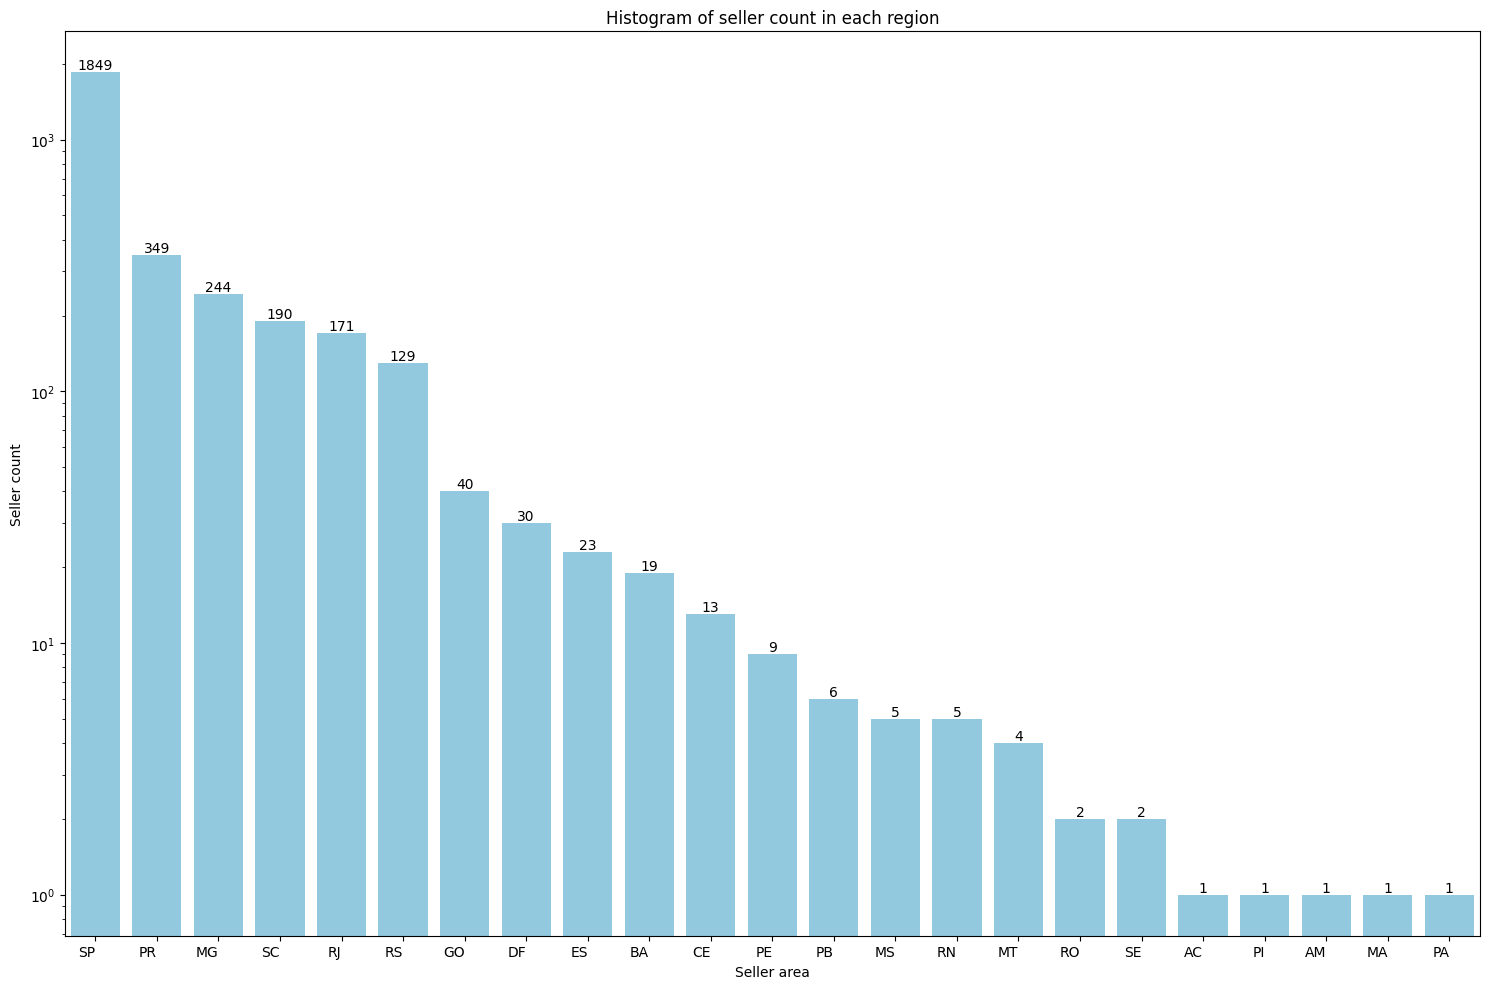

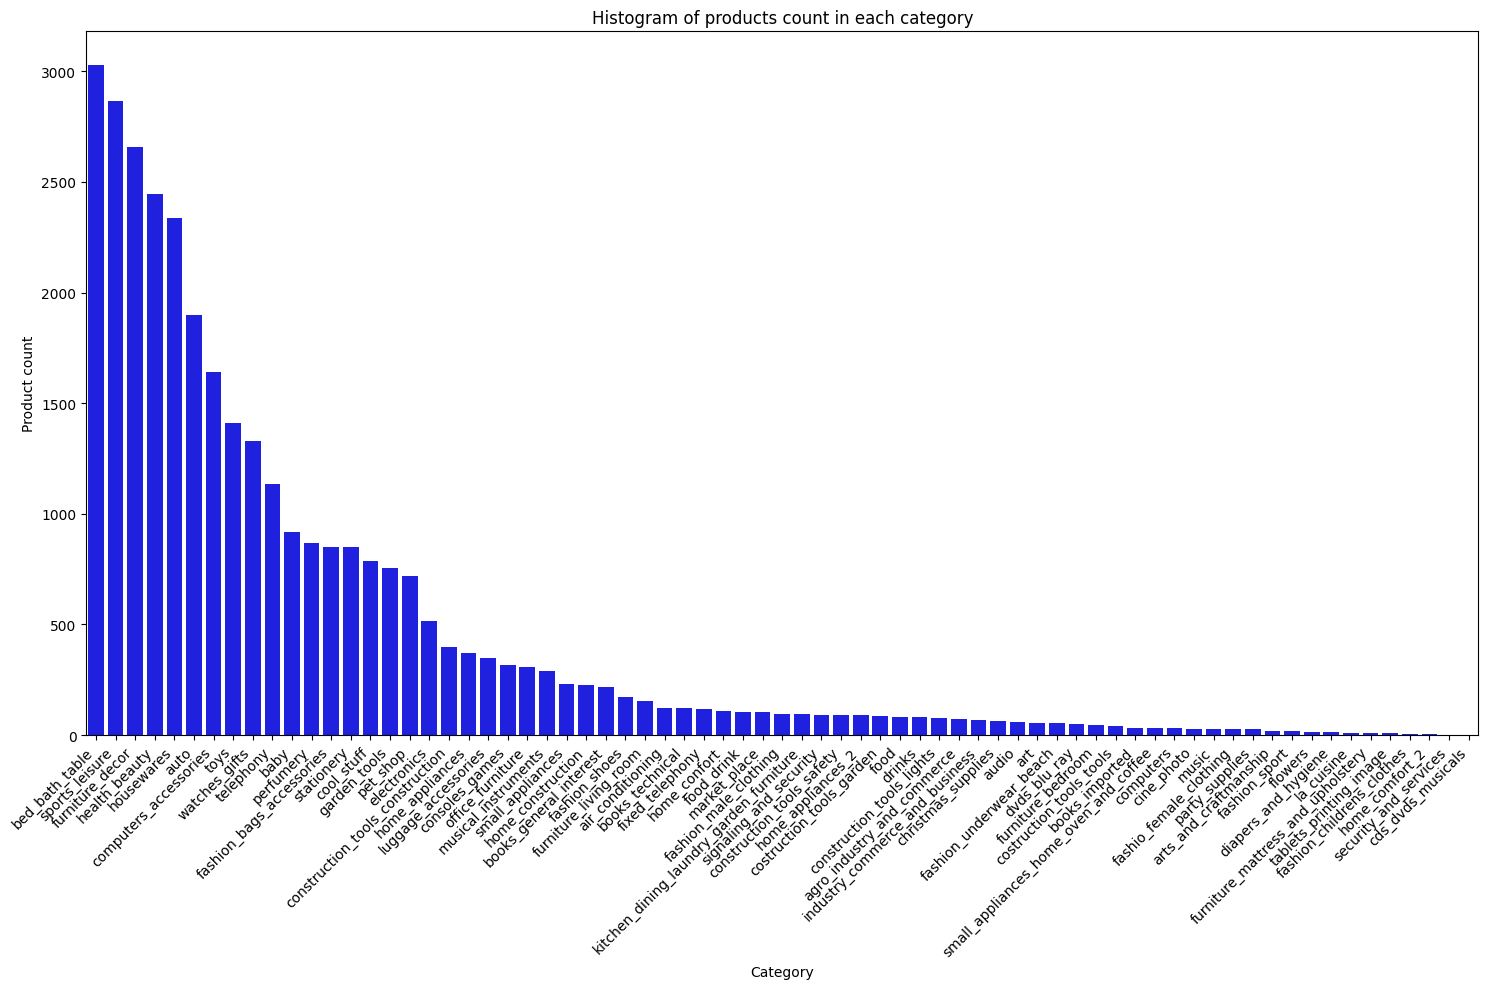

In [25]:
# Sellers segmentation according to geographical region
sellers_by_region = sellers.groupby('seller_state')['seller_id'].count().reset_index()
sellers_by_region = sellers_by_region.rename(columns={'seller_id': 'seller_count'})
sellers_by_region = sellers_by_region.sort_values(by='seller_count', ascending=False).reset_index(drop=True)

# # Grouping products by category
# products_by_category = products['product_category_name'].value_counts().rename_axis('Product category').reset_index(name='Product count')

# # Plotting product count from every category
# plt.figure(figsize=(15, 10))
# plt.bar(products_by_category['Product category'], products_by_category['Product count'], color='blue')
# plt.xlabel('Category')
# plt.ylabel('Product count')
# plt.title('Histogram of products count in each category')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()


plt.figure(figsize=(15, 10))
sns.barplot(x='seller_state', y='seller_count', data=sellers_by_region, color='skyblue', log=True)

# Adding values on top of each bar
for idx, value in enumerate(sellers_by_region['seller_count']):
    plt.text(idx, value, str(value), ha='center', va='bottom')

plt.xlabel('Seller area')
plt.ylabel('Seller count')
plt.title('Histogram of seller count in each region')
plt.xticks(ha='right')
plt.tight_layout()
plt.show()

# Grouping products by category
products_by_category = products['product_category_name'].value_counts().rename_axis('Product category').reset_index(name='Product count')

# Plotting product count from every category with seaborn
plt.figure(figsize=(15, 10))
sns.barplot(x='Product category', y='Product count', data=products_by_category, color='blue')
plt.xlabel('Category')
plt.ylabel('Product count')
plt.title('Histogram of products count in each category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


CONCLUSION
Presented segmentation could prove useful when taking actions in the area of market analysis. Segmentation regarding the number of sellers in a particular region can be useful in analyzing the competitiveness in a particular area and help assess good regions to start a new business. Segmentation concluding the categories of products that sold the most units could help to understand which products are in demand the most and utilize this information to find out new solutions to diversify the range of products or services offered in already established companies. This could also highlight the products or services that are low in demand and are not generating enough turnover to generate a profit for the company/seller.
